In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re as re
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
print(train.isnull().sum()/len(train)*100)
train.head()
test = pd.read_csv('test.csv')
print(test.isnull().sum()/len(test)*100)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64
PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


In [3]:
# OBTAIN SET OF LABELS
Y_train = train.Survived.to_numpy().reshape((-1,1))

In [4]:
# FILL NAN VALUES
# FILL AGE
meanAge = train.Age.mean()
stdAge = train.Age.std()

def fillAge(df, meanAge, stdAge):
    ageNullCount = df.Age.isnull().sum()
    
    randomAgeArray = np.random.randint(meanAge - stdAge, meanAge + stdAge, size=ageNullCount)
    
    df['Age'][np.isnan(df['Age'])] = randomAgeArray
    df['Age'] = df['Age'].astype(int)
    
    return df

train = fillAge(train, meanAge, stdAge)
test = fillAge(test, meanAge, stdAge)

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [5]:
print(train.isnull().sum()/len(train)*100)
print(test.isnull().sum()/len(test)*100)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64
PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


In [6]:
# FILL FARES
print(train[['Fare', 'Pclass']].groupby('Pclass', as_index=False).median())
print(train[['Fare', 'Pclass']].groupby('Pclass', as_index=False).describe())

   Pclass     Fare
0       1  60.2875
1       2  14.2500
2       3   8.0500
    Fare                                                               Pclass  \
   count       mean        std  min       25%      50%   75%       max  count   
0  216.0  84.154687  78.380373  0.0  30.92395  60.2875  93.5  512.3292  216.0   
1  184.0  20.662183  13.417399  0.0  13.00000  14.2500  26.0   73.5000  184.0   
2  491.0  13.675550  11.778142  0.0   7.75000   8.0500  15.5   69.5500  491.0   

                                      
  mean  std  min  25%  50%  75%  max  
0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
1  2.0  0.0  2.0  2.0  2.0  2.0  2.0  
2  3.0  0.0  3.0  3.0  3.0  3.0  3.0  


In [7]:
print(test[['Fare', 'Pclass']].groupby('Pclass', as_index=False).describe())

# only missing value is from third class
np.random.seed(42)
test.Fare = test.Fare.fillna(11.778142 * np.random.rand() + 13.67555) #fill by randomly generating a number in distribution with mean and std from training set
print(test.isnull().sum()/len(test)*100)

    Fare                                                                 \
   count       mean        std     min    25%      50%    75%       max   
0  107.0  94.280297  84.435858  0.0000  30.10  60.0000  134.5  512.3292   
1   93.0  22.202104  13.991877  9.6875  13.00  15.7500   26.0   73.5000   
2  217.0  12.459678  10.803698  3.1708   7.75   7.8958   14.4   69.5500   

  Pclass                                     
   count mean  std  min  25%  50%  75%  max  
0  107.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
1   93.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  
2  218.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0  
PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          78.229665
Embarked        0.000000
dtype: float64


In [8]:
# FILL CABIN
train.Cabin = train.Cabin.fillna('U')
test.Cabin = test.Cabin.fillna('U')

print(train.isnull().sum()/len(train)*100)
print(test.isnull().sum()/len(test)*100)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.000000
Embarked       0.224467
dtype: float64
PassengerId    0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
dtype: float64


In [9]:
# FILL EMBARKED
# MODE IS 'S'
train.Embarked = train.Embarked.fillna('S')
print(train.isnull().sum()/len(train)*100)

PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
dtype: float64


In [10]:
# FEATURE ENGINEERING
# 1. Name
# Need to extract titles
def extractTitles(name):
    title = re.search(' ([A-Za-z]+)\.', name)
    if title:
        return title.group(1)
    return ""

train['Title'] = train['Name'].apply(extractTitles)
test['Title'] = test['Name'].apply(extractTitles)
    
print(train.Title.unique())
print(test.Title.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [11]:
# Clean up titles
print(pd.crosstab(train.Title, train.Sex))

def cleanTitle(df):
    df.Title = df.Title.replace(['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir'], 'Rare')
    df.Title = df.Title.replace(['Ms', 'Mlle'], 'Miss')
    df.Title = df.Title.replace('Mme', 'Mrs')
    
    return df

train = cleanTitle(train)
test = cleanTitle(test)
    
print(train.Title.unique())
print(test.Title.unique())

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1
['Mr' 'Mrs' 'Miss' 'Master' 'Rare']
['Mr' 'Mrs' 'Miss' 'Master' 'Rare']


In [12]:
# See how title affects survival
print(train[['Title', 'Survived']].groupby('Title', as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [13]:
# 2. Whether alone or with family
def isNotAlone(df):
    df['IsNotAlone'] = 1
    df.loc[df['SibSp'] + df['Parch'] == 0, 'IsNotAlone'] = 0
    
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    return df

train = isNotAlone(train)
test = isNotAlone(test)

print(train[['IsNotAlone', 'Survived']].groupby('IsNotAlone', as_index=False).mean())

   IsNotAlone  Survived
0           0  0.303538
1           1  0.505650


In [14]:
# 3. Whether has a cabin or not
def hasCabin(df):
    df['HasCabin'] = 1
    df.loc[df['Cabin']=='U', 'HasCabin'] = 0
    
    return df

train = hasCabin(train)
test = hasCabin(test)
    
print(train[['HasCabin', 'Survived']].groupby('HasCabin', as_index=False).mean())

   HasCabin  Survived
0         0  0.299854
1         1  0.666667


In [15]:
# 4. Sex matters
print(train[['Sex', 'Survived']].groupby('Sex', as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [16]:
# 5. Age matters
train['CategoricalAge'] = pd.qcut(train['Age'], 5)
print(train[['CategoricalAge', 'Survived']].groupby('CategoricalAge', as_index=False).mean())

   CategoricalAge  Survived
0  (-0.001, 19.0]  0.467005
1    (19.0, 25.0]  0.307692
2    (25.0, 32.0]  0.378238
3    (32.0, 40.0]  0.390244
4    (40.0, 80.0]  0.363095


In [17]:
# 6. Where they embarked from
print(train[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


In [18]:
# 7. Class
print(train[['Pclass', 'Survived']].groupby('Pclass', as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [19]:
# 8. Fare
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print(train[['CategoricalFare', 'Survived']].groupby('CategoricalFare', as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [20]:
train = train.drop(['CategoricalFare', 'CategoricalAge'], axis=1) # drop dummy columns
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsNotAlone,FamilySize,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,U,S,Mr,1,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Mrs,1,2,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,U,S,Miss,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs,1,2,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,U,S,Mr,0,1,0


In [21]:
# process data for training
def process(df):
    # remove unneccessary columns
    dropColumns = ['PassengerId', 'SibSp', 'Parch', 'Name', 'Ticket', 'Cabin']
    df = df.drop(dropColumns, axis=1)
    print(df.columns)
    
    # map title column
    titleMapping = {'Mr':0, 'Rare':1, 'Master':2, 'Miss':3, 'Mrs':4}
    df.Title = df.Title.map(titleMapping)
    
    # map sex column
    sexMapping = {'male':0, 'female':1}
    df.Sex = df.Sex.map(sexMapping)
    
    # map age column
    
    df.loc[df['Age'] <= 19, 'Age'] = 4
    df.loc[(df['Age'] > 19) & (df['Age'] <= 25), 'Age'] = 0
    df.loc[df['Age'] > 40, 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 40), 'Age'] = 2
    df.loc[(df['Age'] > 25) & (df['Age'] <= 32), 'Age'] = 3
    
    # map fare column
    df.loc[df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31.0), 'Fare'] = 2
    df.loc[df['Fare'] > 31.0, 'Fare'] = 3
    
    # map embarked column
    embarkedMapping = {'S':0, 'Q':1, 'C':2}
    df.Embarked = df.Embarked.map(embarkedMapping)
    
    print(df.head())
    
    return df

train = process(train)
test = process(test)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title',
       'IsNotAlone', 'FamilySize', 'HasCabin'],
      dtype='object')
   Survived  Pclass  Sex  Age  Fare  Embarked  Title  IsNotAlone  FamilySize  \
0         0       3    0    0   0.0         0      0           1           2   
1         1       1    1    2   3.0         2      4           1           2   
2         1       3    1    3   1.0         0      3           0           1   
3         1       1    1    2   3.0         0      4           1           2   
4         0       3    0    2   1.0         0      0           0           1   

   HasCabin  
0         0  
1         1  
2         0  
3         1  
4         0  
Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'IsNotAlone',
       'FamilySize', 'HasCabin'],
      dtype='object')
   Pclass  Sex  Age  Fare  Embarked  Title  IsNotAlone  FamilySize  HasCabin
0       3    0    2   0.0         1      0           0           1         0
1       3

In [22]:
train.to_csv('processed_train.csv', index=False)
test.to_csv('processed_test.csv', index=False)

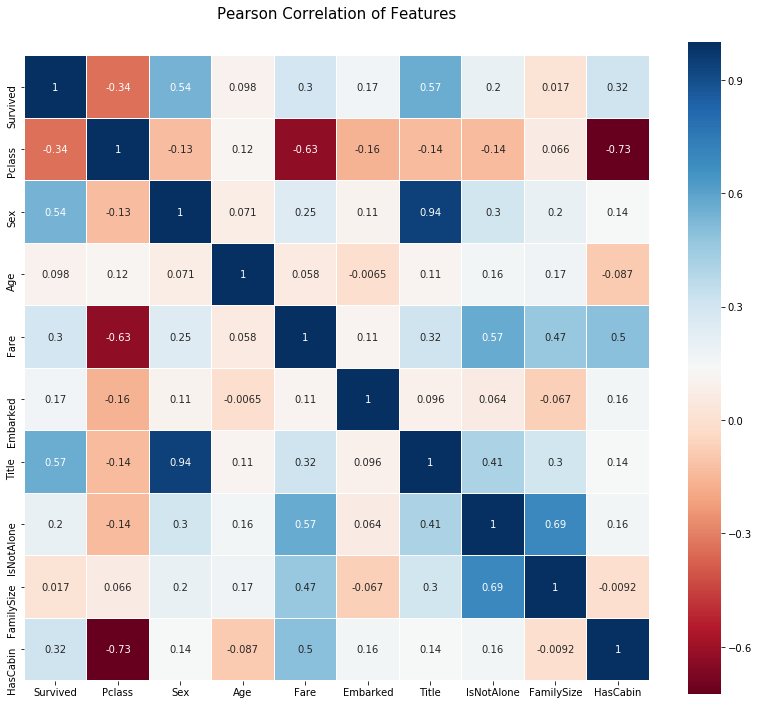

In [23]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)